# TinyImageNet


In [1]:
import os, random, zipfile, urllib.request
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

1 Download TinyImageNet Subset (if not present)

In [2]:
data_root = "./TinyImageNet"
zip_path = os.path.join(data_root, "tiny-imagenet-200.zip")
extract_path = os.path.join(data_root, "tiny-imagenet-200")

if not os.path.exists(extract_path):
    os.makedirs(data_root, exist_ok=True)
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    print(" Downloading TinyImageNet (~250MB)...")
    urllib.request.urlretrieve(url, zip_path)
    print(" Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)
    print(" Done.")
else:
    print(" TinyImageNet already available.")


 TinyImageNet already available.


2 Strong NUI Mask Generator

In [3]:
def generate_directional_mask(h, w, strength=3.0, exponent=2.0):
    yy, xx = np.meshgrid(np.linspace(-1, 1, h), np.linspace(-1, 1, w), indexing='ij')
    angle = np.random.uniform(0, np.pi)
    grad = np.cos(angle) * xx + np.sin(angle) * yy
    grad = (grad - grad.min()) / (grad.max() - grad.min())
    mask = grad ** exponent
    mask = 1 + strength * (mask - 0.5)
    mask = np.clip(mask, 0, 2).astype(np.float32)
    return mask

def apply_mask_to_tensor(img_tensor, mask):
    mask = torch.tensor(mask).unsqueeze(0)
    if img_tensor.shape[1:] != mask.shape[1:]:
        mask = torch.nn.functional.interpolate(
            mask.unsqueeze(0), size=img_tensor.shape[1:], mode='bilinear', align_corners=False
        ).squeeze(0)
    return img_tensor * mask
   

3 Load TinyImageNet Subset (5 classes only, fixed labels)

In [4]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
])

dataset_path = os.path.join(extract_path, "train")
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
print("Total TinyImageNet train samples:", len(full_dataset))

# Pick 8 random classes
class_indices = random.sample(range(200), 8)
print("Selected class indices:", class_indices)

#  Build class mapping (old → new)
label_map = {old: new for new, old in enumerate(class_indices)}

#  Filter dataset for only these classes
subset_samples = [
    (path, label_map[label]) for path, label in full_dataset.samples if label in class_indices
]

#  Replace samples and targets
full_dataset.samples = subset_samples
full_dataset.targets = [label for _, label in subset_samples]

# Take subset of 2000 images
subset_idx = list(range(min(2000, len(full_dataset.samples))))
dataset = Subset(full_dataset, subset_idx)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

num_classes = len(class_indices)
print(f"Training samples: {len(trainset)} | Test samples: {len(testset)} | Classes: {num_classes}")


Total TinyImageNet train samples: 100000
Selected class indices: [74, 191, 28, 148, 57, 5, 134, 8]
Training samples: 1600 | Test samples: 400 | Classes: 8


4  Tiny CNN Model

In [5]:
class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 128), nn.ReLU(), nn.Dropout(0.4), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

5 Train & Eval Functions

In [6]:
def train_model(model, loader, optimizer, criterion, epochs=3, apply_nui=False):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            if apply_nui:
                imgs_aug = []
                for img in imgs:
                    if np.random.rand() < 0.7:
                        mask = generate_directional_mask(64, 64,
                            strength=np.random.uniform(-3.0, 3.0),
                            exponent=np.random.uniform(0.8, 3.5)
                        )
                        img = apply_mask_to_tensor(img, mask)
                    imgs_aug.append(img)
                imgs = torch.stack(imgs_aug)
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(imgs), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Loss: {total_loss / len(loader):.4f}")

def evaluate(model, loader, apply_nui=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            if apply_nui:
                imgs_aug = []
                for img in imgs:
                    mask = generate_directional_mask(64, 64, strength=3.0, exponent=2.0)
                    img = apply_mask_to_tensor(img, mask)
                    imgs_aug.append(img)
                imgs = torch.stack(imgs_aug)
            imgs, labels = imgs.to(device), labels.to(device)
            _, predicted = model(imgs).max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total


6 Visualization Function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


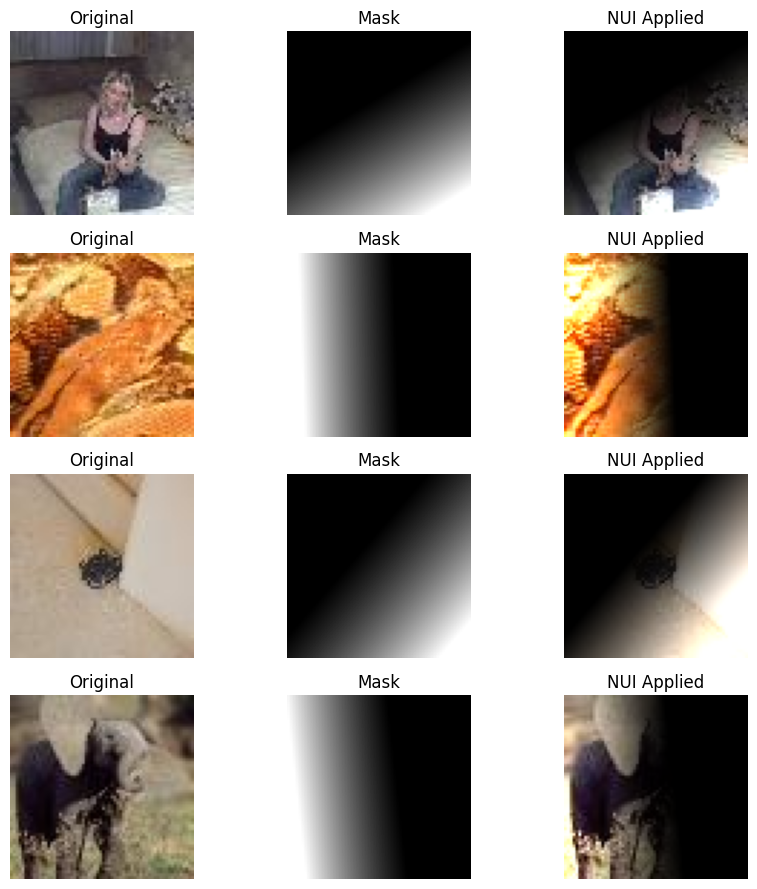

In [7]:
def visualize_nui_effect(num_images=4):
    imgs, _ = next(iter(testloader))
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 9))
    for i in range(num_images):
        img = imgs[i]
        mask = generate_directional_mask(64, 64, strength=3.0, exponent=2.0)
        img_nui = apply_mask_to_tensor(img, mask)
        axes[i,0].imshow(img.permute(1,2,0)); axes[i,0].set_title("Original"); axes[i,0].axis("off")
        axes[i,1].imshow(mask, cmap="gray"); axes[i,1].set_title("Mask"); axes[i,1].axis("off")
        axes[i,2].imshow(img_nui.permute(1,2,0)); axes[i,2].set_title("NUI Applied"); axes[i,2].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize few samples
visualize_nui_effect()

7 Baseline vs Robust Training

In [8]:
criterion = nn.CrossEntropyLoss()

# Baseline Model
model_clean = TinyCNN(num_classes).to(device)
optimizer = optim.Adam(model_clean.parameters(), lr=0.001)
print("\n=== Training Baseline Model (Clean) ===")
train_model(model_clean, trainloader, optimizer, criterion, epochs=3, apply_nui=False)
acc_clean = evaluate(model_clean, testloader, apply_nui=False)
acc_nui = evaluate(model_clean, testloader, apply_nui=True)
print(f"\nBefore Robust Training:\nClean: {acc_clean*100:.2f}% | NUI: {acc_nui*100:.2f}%")

# NUI-Augmented Model
model_nui = TinyCNN(num_classes).to(device)
optimizer = optim.Adam(model_nui.parameters(), lr=0.001)
print("\n=== Training Robust Model (NUI-Augmented) ===")
train_model(model_nui, trainloader, optimizer, criterion, epochs=3, apply_nui=True)
acc_clean_aug = evaluate(model_nui, testloader, apply_nui=False)
acc_nui_aug = evaluate(model_nui, testloader, apply_nui=True)
print(f"\nAfter NUI-Augmented Training:\nClean: {acc_clean_aug*100:.2f}% | NUI: {acc_nui_aug*100:.2f}%")
print("-" * 40)
print(f"Accuracy Drop Before: {abs(acc_clean - acc_nui)*100:.2f}%")
print(f"Accuracy Drop After:  {abs(acc_clean_aug - acc_nui_aug)*100:.2f}%")
drop_before = abs(acc_clean - acc_nui)*100
drop_after = abs(acc_clean_aug - acc_nui_aug)*100
improvement = drop_before - drop_after
print(f"   NUI Robustness Improvement: {improvement:.2f}%")


=== Training Baseline Model (Clean) ===


Epoch 1/3: 100%|██████████| 25/25 [00:20<00:00,  1.19it/s]


Loss: 2.0581


Epoch 2/3: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


Loss: 1.0186


Epoch 3/3: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Loss: 0.9124

Before Robust Training:
Clean: 61.75% | NUI: 41.50%

=== Training Robust Model (NUI-Augmented) ===


Epoch 1/3: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


Loss: 1.9008


Epoch 2/3: 100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Loss: 1.2190


Epoch 3/3: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Loss: 1.0923

After NUI-Augmented Training:
Clean: 60.00% | NUI: 44.50%
----------------------------------------
Accuracy Drop Before: 20.25%
Accuracy Drop After:  15.50%
   NUI Robustness Improvement: 4.75%
